In [4]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.transforms import get_sparse_operator
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
basis='sto-3g'
multiplicity=1
charge=0
distance=0.977
geometry=[['H',[0,0,0]],['H',[0,0,distance]]]
description='tmp'
molecule=MolecularData(geometry,basis,multiplicity,charge,description)
molecule=run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit=molecule.n_qubits
n_ele=molecule.n_electrons
fermionic_hamiltonian=get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian=jordan_wigner(fermionic_hamiltonian)

In [8]:
jw_hamiltonian

(-0.31349601534094224+0j) [] +
(-0.04883472636540648+0j) [X0 X1 Y2 Y3] +
(0.04883472636540648+0j) [X0 Y1 Y2 X3] +
(0.04883472636540648+0j) [Y0 X1 X2 Y3] +
(-0.04883472636540648+0j) [Y0 Y1 X2 X3] +
(0.13978238294522735+0j) [Z0] +
(0.1576263055158343+0j) [Z0 Z1] +
(0.10745382591353006+0j) [Z0 Z2] +
(0.15628855227893657+0j) [Z0 Z3] +
(0.13978238294522735+0j) [Z1] +
(0.15628855227893657+0j) [Z1 Z2] +
(0.10745382591353006+0j) [Z1 Z3] +
(-0.13686895093682833+0j) [Z2] +
(0.16419290100986608+0j) [Z2 Z3] +
(-0.13686895093682833+0j) [Z3]

In [9]:
from qulacs import QuantumState, QuantumCircuit

In [10]:
from qulacs.gate import CZ, RY, RZ, merge
depth = n_qubit

In [15]:
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian= create_observable_from_openfermion_text(str(jw_hamiltonian))

In [11]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    '''
    Returns hardware efficient ansatz circuit.
    
    Args:
        n_qubit
        depth
        theta_list
    Returns:
        qulacs.QuantumCircuit
    '''
    circuit=QuantumCircuit(n_qubit)
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]),RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i,2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1,2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]),RZ(i, theta_list[2*i+1+2*n_qubit*depth])))
    return circuit

In [13]:
def cost(theta_list):
    state=QuantumState(n_qubit)
    circuit=he_ansatz_circuit(n_qubit, depth, theta_list)
    circuit.update_quantum_state(state)
    return qulacs_hamiltonian.get_expectation_value(state)

In [20]:
hist=[]
init_theta_list=np.random.random(2*n_qubit*(depth+1))*1e-1
hist.append(cost(init_theta_list))
method='BFGS'
options={'disp': True,'maxiter':50,'gtol': 1e-6}
opt=minimize(cost,init_theta_list,method=method,callback=lambda x: hist.append(cost(x)))


In [21]:
hist

[0.4903270911806086,
 -0.15652438655642456,
 -0.5888762488054455,
 -0.6056665100476724,
 -0.6317582441104761,
 -0.6777077161871174,
 -0.7074051362749617,
 -0.7212490950057864,
 -0.7377159291605135,
 -0.8222800269523121,
 -0.8341778623204754,
 -0.8570047921786704,
 -0.9001742263065499,
 -0.9717340325818284,
 -1.016365495945041,
 -1.0426455304156912,
 -1.0520798800370659,
 -1.0621172439520894,
 -1.0710919468820186,
 -1.0758383866414798,
 -1.079136070131017,
 -1.0818764490378205,
 -1.084312608695678,
 -1.0882241716807886,
 -1.0934787008350306,
 -1.096788956278663,
 -1.0989148500245924,
 -1.0999722213994392,
 -1.1015815291101816,
 -1.10337184085947,
 -1.104545680619707,
 -1.1053937330343069,
 -1.105564012691579,
 -1.105661940805548,
 -1.1057540837705828,
 -1.1058352585356737,
 -1.105878209280548,
 -1.1058876727295333,
 -1.105890300639542,
 -1.1058933412991507,
 -1.1058983918471248,
 -1.1059062300504512,
 -1.1059140448224236,
 -1.1059174918828545,
 -1.1059198681173477,
 -1.1059214860719846,

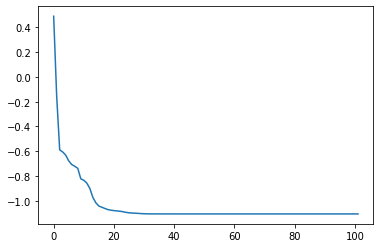

In [22]:
plt.plot(hist)

In [23]:
[1]*2

[1, 1]